# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [3]:
# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset)

Files already downloaded and verified
Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Evaluating the training procedure is difficult because of::

Small Size of Training Dataset:
Selecting only 100 samples from a larger set of 50,000 poses a challenge in maintaining a balanced representation across classes in the CIFAR-10 dataset. This limitation might result in certain classes being underrepresented, which could skew the model's learning process. A balanced representation of classes is essential to avoid biasing the model towards certain classes while neglecting others.

To counteract this, a strategic approach to sample selection is crucial, aiming to ensure that the selected samples fairly represent the diversity of classes within the CIFAR-10 dataset. Employing resampling strategies such as downsampling or oversampling can help address imbalances in class representation. Tools like RandomUnderSampler and RandomOverSampler, from the imbalanced-learn library, offer practical solutions to adjust the dataset composition for a more balanced training approach.

Risk of Overfitting:
The limited size of the dataset increases the risk of overfitting, where the model learns the specifics of the training data too closely and fails to generalize to new data. This could degrade the model's performance when encountering the test dataset, as it may not effectively apply learned patterns to unseen data.

Implementing data augmentation strategies can artificially enlarge the training dataset through transformations such as rotations, scalings, and flips on existing samples, introducing variability and promoting a more generalized learning process. Furthermore, incorporating weak supervision methods can enhance the labeled dataset. Techniques like semi-supervised and self-supervised learning leverage unlabeled data to expand the training set, potentially improving model outcomes. By progressively labeling portions of the unlabeled data and integrating them into the training phase, the model's exposure is broadened, helping to overcome the constraints of a limited dataset.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [5]:
# Source of the following code: https://github.com/kuangliu/pytorch-cifar

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

# test()

In [4]:
def run_epoch(model, data_loader, loss_fn, opt, device, is_train=True, scheduler=None, verbose=True):
    """
    Runs a training or evaluation epoch.
    
    Args:
        model (torch.nn.Module): The model to train or evaluate.
        data_loader (torch.utils.data.DataLoader): The DataLoader for input data.
        loss_fn (callable): The loss function.
        opt (torch.optim.Optimizer): The optimizer for training.
        device (torch.device): The device to run the model on.
        is_train (bool): Specifies if the model should be in training mode.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        verbose (bool): If True, prints progress using tqdm.
        
    Returns:
        tuple: Mean loss and accuracy for the epoch.
    """
    if is_train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_corrects = 0
    
    for inputs, labels in tqdm(data_loader, disable=not verbose):
        inputs, labels = inputs.to(device), labels.to(device)
        
        with torch.set_grad_enabled(is_train):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            if is_train:
                opt.zero_grad()
                loss.backward()
                opt.step()
                if scheduler is not None:
                    scheduler.step()
        
        total_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        total_corrects += torch.sum(preds == labels.data)
    
    mean_loss = total_loss / len(data_loader.dataset)
    mean_accuracy = total_corrects.double() / len(data_loader.dataset)
    
    return mean_loss, mean_accuracy

def train_and_test(model, train_loader, test_loader, loss_fn, opt, device, epochs=10, scheduler=None, verbose=True):
    """
    Trains and evaluates a model.
    
    Args:
        model (torch.nn.Module): The model to train and evaluate.
        train_loader (torch.utils.data.DataLoader): The DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): The DataLoader for test data.
        loss_fn (callable): The loss function.
        opt (torch.optim.Optimizer): The optimizer for training.
        device (torch.device): The device to run the model on.
        epochs (int): Number of training epochs.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        verbose (bool): If True, prints progress and results.
        
    Returns:
        dict: A dictionary containing training and test losses and accuracies.
    """
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    for epoch in range(epochs):
        if verbose: print(f'Epoch {epoch+1}/{epochs}')
        
        # Run training epoch
        train_loss, train_acc = run_epoch(model, train_loader, loss_fn, opt, device, is_train=True, scheduler=scheduler, verbose=verbose)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Run evaluation epoch
        test_loss, test_acc = run_epoch(model, test_loader, loss_fn, opt, device, is_train=False, verbose=verbose)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        if verbose:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    if verbose: print('Finished Training')
    
    return history


In [33]:
# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 10

# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Storage of the results for ResNet18 model
resnet18_train_acc = history['train_acc']
resnet18_test_acc = history['test_acc']

resnet18_train_acc = [tensor.cpu().numpy() for tensor in resnet18_train_acc]
resnet18_train_acc = np.array(resnet18_train_acc)

resnet18_test_acc = [tensor.cpu().numpy() for tensor in resnet18_test_acc]
resnet18_test_acc = np.array(resnet18_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 68.25it/s]


Epoch 1/10, Train Loss: 2.9490, Train Acc: 0.1700, Test Loss: 7.5198, Test Acc: 0.0739
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 68.78it/s]


Epoch 2/10, Train Loss: 2.3874, Train Acc: 0.2000, Test Loss: 4.6420, Test Acc: 0.0539
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


Epoch 3/10, Train Loss: 1.9685, Train Acc: 0.3200, Test Loss: 3.0744, Test Acc: 0.1863
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 68.87it/s]


Epoch 4/10, Train Loss: 1.6861, Train Acc: 0.4000, Test Loss: 2.3786, Test Acc: 0.1979
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 68.91it/s]


Epoch 5/10, Train Loss: 1.6251, Train Acc: 0.4400, Test Loss: 2.2361, Test Acc: 0.2048
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 68.87it/s]


Epoch 6/10, Train Loss: 1.5448, Train Acc: 0.5000, Test Loss: 2.1725, Test Acc: 0.2123
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 68.92it/s]


Epoch 7/10, Train Loss: 1.5778, Train Acc: 0.5000, Test Loss: 2.1736, Test Acc: 0.2141
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 68.85it/s]


Epoch 8/10, Train Loss: 1.4665, Train Acc: 0.5400, Test Loss: 2.1674, Test Acc: 0.2137
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 68.97it/s]


Epoch 9/10, Train Loss: 1.4893, Train Acc: 0.5200, Test Loss: 2.1694, Test Acc: 0.2140
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 69.03it/s]

Epoch 10/10, Train Loss: 1.4314, Train Acc: 0.5900, Test Loss: 2.1615, Test Acc: 0.2151
Finished Training
Test loss: 2.1615, Test accuracy: 0.2151


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18  | 10 | 59.00% | 21.51% |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [39]:
from torchvision.models import resnet18, ResNet18_Weights # We chose the ResNet18 for comparison sake

# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 10

# Load training dataset
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)
# Adapt it for CIFAR10
model.fc = nn.Linear(512, 10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Sotrage of the results for Pre-trained ResNet18 model
pretrained_resnet18_train_acc = history['train_acc']
pretrained_resnet18_test_acc = history['test_acc']

pretrained_resnet18_train_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_train_acc]
pretrained_resnet18_train_acc = np.array(pretrained_resnet18_train_acc)

pretrained_resnet18_test_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_test_acc]
pretrained_resnet18_test_acc = np.array(pretrained_resnet18_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 98.69it/s]


Epoch 1/10, Train Loss: 2.9863, Train Acc: 0.2200, Test Loss: 2.7933, Test Acc: 0.1611
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 99.07it/s]


Epoch 2/10, Train Loss: 2.1128, Train Acc: 0.4000, Test Loss: 2.7232, Test Acc: 0.1986
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 99.25it/s]


Epoch 3/10, Train Loss: 1.3159, Train Acc: 0.5800, Test Loss: 3.2238, Test Acc: 0.2184
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 99.05it/s]


Epoch 4/10, Train Loss: 0.9146, Train Acc: 0.6500, Test Loss: 2.6006, Test Acc: 0.2548
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 99.10it/s]


Epoch 5/10, Train Loss: 0.7688, Train Acc: 0.7400, Test Loss: 2.5253, Test Acc: 0.2528
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 99.19it/s]


Epoch 6/10, Train Loss: 0.6539, Train Acc: 0.7800, Test Loss: 2.5575, Test Acc: 0.2581
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 99.34it/s]


Epoch 7/10, Train Loss: 0.7191, Train Acc: 0.7500, Test Loss: 2.5289, Test Acc: 0.2625
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 99.41it/s]


Epoch 8/10, Train Loss: 0.5063, Train Acc: 0.8400, Test Loss: 2.5284, Test Acc: 0.2604
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 99.29it/s]


Epoch 9/10, Train Loss: 0.5110, Train Acc: 0.8500, Test Loss: 2.5487, Test Acc: 0.2646
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 99.02it/s]

Epoch 10/10, Train Loss: 0.5808, Train Acc: 0.8400, Test Loss: 2.5397, Test Acc: 0.2636
Finished Training
Test loss: 2.5397, Test accuracy: 0.2636


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Pre-trained ResNet18  | 10 | 84.00% | 26.36% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

When manipulating 32x32 images through translations, rotations, scaling, and color adjustments, various challenges may emerge, including:

- Information Loss: Transformations such as rotations and scaling can result in crucial details being lost, impeding the model's learning efficiency.

- Boundary Issues: Image edges might suffer from distortion or truncation due to translations, rotations, and scaling, creating boundary artifacts.

- Aliasing Effects: Scaling down or rotating images can introduce aliasing, degrading image quality by adding high-frequency noise.

- Color Shifts: Altering an image's color, brightness, or contrast may change object appearances, complicating the model's ability to recognize consistent patterns across varying color schemes.

To address these concerns, consider implementing the following strategies:

- Padding: Incorporate padding around images before applying transformations to prevent edge information loss.

- Interpolation Techniques: Employ suitable interpolation methods for scaling to minimize aliasing and preserve image integrity.

- Anti-Aliasing Filters: Utilize anti-aliasing filters when reducing image size to avoid aliasing effects. For enlarging images, reconstruction filters are recommended to maintain smoothness and clarity.

- Color Normalization: Standardize the color channels to a common range prior to color adjustments to maintain balanced color transformations and realistic distributions.

- Augmentation Oversight: Regular examination of augmented images is crucial to ensure that the applied modifications do not introduce unrealistic changes or negatively impact model training.

- Controlled Data Augmentation: Enrich training datasets with a variety of transformations while cautiously managing the extent of modifications to avoid significant distortion or detail loss. Strategies include:

    - Adaptive Augmentation: Adjust the augmentation intensity based on the dataset's specific attributes, applying milder transformations to images with intricate details or complex backgrounds.

    - Domain-Specific Augmentation: Customize augmentation approaches to fit the unique requirements of the target domain, such as incorporating relevant expertise for medical imagery to preserve essential diagnostic features.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

- **RandomHorizontalFlip**: Flips images horizontally with a probability of 0.5, effectively increasing the diversity of object orientations in the dataset, which is beneficial for tasks where object orientation is not critical.

- **RandomVerticalFlip**: Similar to horizontal flipping but in the vertical direction, it ensures that the model learns to recognize objects from different perspectives, further enhancing its ability to generalize.

- **RandomRotation(degrees=15)**: Randomly rotates images by up to 15 degrees in both clockwise and counterclockwise directions. This variation simulates real-world scenarios where objects may be tilted or rotated, encouraging the model to learn features invariant to rotation.

- **RandomResizedCrop(32, scale=(0.8, 1.0))**: Randomly crops and resizes images to a size of 32x32 pixels, with a scale factor ranging from 0.8 to 1.0. This transformation helps the model focus on different parts of the image while preserving spatial relationships, aiding in robust feature learning.

- **ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)**: Randomly adjusts brightness, contrast, saturation, and hue of the images, introducing variations in color distribution. This ensures that the model learns to recognize objects under different lighting conditions and color variations, making it more adaptable to real-world scenarios.

In [53]:
# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 55

# Load training dataset with additional transformations
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_dataset_transformed = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
]))
train_dataset_transformed2 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),  # Random vertical flip
]))
train_dataset_transformed3 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),   # Random rotation up to 15 degrees
]))
train_dataset_transformed4 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
]))
train_dataset_transformed5 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
]))
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_subset_transformed = torch.utils.data.Subset(train_dataset_transformed, indices=range(100))
train_subset_transformed2 = torch.utils.data.Subset(train_dataset_transformed2, indices=range(100))
train_subset_transformed3 = torch.utils.data.Subset(train_dataset_transformed3, indices=range(100))
train_subset_transformed4 = torch.utils.data.Subset(train_dataset_transformed4, indices=range(100))
train_subset_transformed5 = torch.utils.data.Subset(train_dataset_transformed5, indices=range(100))
concatenated_dataset = torch.utils.data.ConcatDataset([train_subset, train_subset_transformed, train_subset_transformed2, train_subset_transformed3, train_subset_transformed4, train_subset_transformed5])
train_loader = torch.utils.data.DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Storage of the results for the ResNet18 after Data Augmentation model
resnet18_augmented_train_acc = history['train_acc']
resnet18_augmented_test_acc = history['test_acc']

resnet18_augmented_train_acc = [tensor.cpu().numpy() for tensor in resnet18_augmented_train_acc]
resnet18_augmented_train_acc = np.array(resnet18_augmented_train_acc)

resnet18_augmented_test_acc = [tensor.cpu().numpy() for tensor in resnet18_augmented_test_acc]
resnet18_augmented_test_acc = np.array(resnet18_augmented_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 70.67it/s]


Epoch 1/10, Train Loss: 2.2313, Train Acc: 0.3167, Test Loss: 2.4935, Test Acc: 0.1345
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 70.70it/s]


Epoch 2/10, Train Loss: 1.3184, Train Acc: 0.5450, Test Loss: 3.3398, Test Acc: 0.1220
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 70.66it/s]


Epoch 3/10, Train Loss: 0.8761, Train Acc: 0.7083, Test Loss: 3.7229, Test Acc: 0.1872
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 70.59it/s]


Epoch 4/10, Train Loss: 0.5774, Train Acc: 0.8417, Test Loss: 3.1284, Test Acc: 0.2249
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 70.45it/s]


Epoch 5/10, Train Loss: 0.4078, Train Acc: 0.8883, Test Loss: 3.0100, Test Acc: 0.2558
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 70.44it/s]


Epoch 6/10, Train Loss: 0.3064, Train Acc: 0.9233, Test Loss: 3.0440, Test Acc: 0.2619
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 70.62it/s]


Epoch 7/10, Train Loss: 0.2997, Train Acc: 0.9233, Test Loss: 3.0346, Test Acc: 0.2661
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 70.62it/s]


Epoch 8/10, Train Loss: 0.3300, Train Acc: 0.9167, Test Loss: 3.0385, Test Acc: 0.2643
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 70.61it/s]


Epoch 9/10, Train Loss: 0.2531, Train Acc: 0.9367, Test Loss: 3.0634, Test Acc: 0.2640
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 70.59it/s]

Epoch 10/10, Train Loss: 0.2637, Train Acc: 0.9417, Test Loss: 3.0584, Test Acc: 0.2653
Finished Training
Test loss: 3.0584, Test accuracy: 0.2653


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 after Data Augmentation | 10 | 94.17% | 26.53% |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

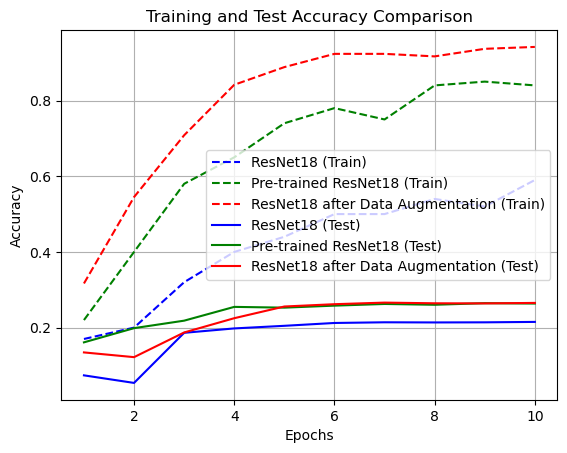

In [65]:
epochs = range(1, 11)

# Plot training accuracy
plt.plot(epochs, resnet18_train_acc, linestyle='--', label='ResNet18 (Train)', color='b')
plt.plot(epochs, pretrained_resnet18_train_acc, linestyle='--', label='Pre-trained ResNet18 (Train)', color='g')
plt.plot(epochs, resnet18_augmented_train_acc, linestyle='--', label='ResNet18 after Data Augmentation (Train)', color='r')

# Plot test accuracy
plt.plot(epochs, resnet18_test_acc, label='ResNet18 (Test)', color='b')
plt.plot(epochs, pretrained_resnet18_test_acc, label='Pre-trained ResNet18 (Test)', color='g')
plt.plot(epochs, resnet18_augmented_test_acc, label='ResNet18 after Data Augmentation (Test)', color='r')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 after Data Augmentation | 10 | 94.17% | 26.53% |
|   Pre-trained ResNet18  | 10 | 84.00% | 26.36% |
|   ResNet18  | 10 | 59.00% | 21.51% |

Pretraining was done on ImageNet, which is a different dataset from CIFAR10. We observe that increasing (times 6) our labeled CIFAR10 training set's size using data augmentations on the non-pretrained ResNet18 proves slightly more efficient than pretraining on ImageNet.

Thus, it seems that transfer learning from one dataset to another is less efficient than a training from scratch, robustified by data augmentations.

It would be promising to test pretraining followed by finetuning on an augmented dataset

In [5]:
from torchvision.models import resnet18, ResNet18_Weights

# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 55

# Load training dataset with additional transformations
train_dataset = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.ToTensor())
train_dataset_transformed = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
]))
train_dataset_transformed2 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),  # Random vertical flip
]))
train_dataset_transformed3 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),   # Random rotation up to 15 degrees
]))
train_dataset_transformed4 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter
]))
train_dataset_transformed5 = torchvision.datasets.CIFAR10(root="\content", train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random resized crop
]))
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100)) 
train_subset_transformed = torch.utils.data.Subset(train_dataset_transformed, indices=range(100))
train_subset_transformed2 = torch.utils.data.Subset(train_dataset_transformed2, indices=range(100))
train_subset_transformed3 = torch.utils.data.Subset(train_dataset_transformed3, indices=range(100))
train_subset_transformed4 = torch.utils.data.Subset(train_dataset_transformed4, indices=range(100))
train_subset_transformed5 = torch.utils.data.Subset(train_dataset_transformed5, indices=range(100))
concatenated_dataset = torch.utils.data.ConcatDataset([train_subset, train_subset_transformed, train_subset_transformed2, train_subset_transformed3, train_subset_transformed4, train_subset_transformed5])
train_loader = torch.utils.data.DataLoader(concatenated_dataset, batch_size=batch_size, shuffle=True)

# Load test dataset
test_dataset = torchvision.datasets.CIFAR10(root="\content", train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Prepare the model, device, optimizer, scheduler, and loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights).to(device)
# Adapt it for CIFAR10
model.fc = nn.Linear(512, 10).to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = torch.nn.CrossEntropyLoss()

# Train and test the model
history = train_and_test(model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)


# Storage of the results for the ResNet18 after Data Augmentation model
pretrained_resnet18_augmented_train_acc = history['train_acc']
pretrained_resnet18_augmented_test_acc = history['test_acc']

pretrained_resnet18_augmented_train_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_augmented_train_acc]
pretrained_resnet18_augmented_train_acc = np.array(pretrained_resnet18_augmented_train_acc)

pretrained_resnet18_augmented_test_acc = [tensor.cpu().numpy() for tensor in pretrained_resnet18_augmented_test_acc]
pretrained_resnet18_augmented_test_acc = np.array(pretrained_resnet18_augmented_test_acc)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


  0%|          | 0/11 [00:00<?, ?it/s]/users/eleves-b/2020/celestin.eve/miniconda3/envs/deep-env2/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025831482/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 100/100 [00:01<00:00, 93.72it/s]


Epoch 1/10, Train Loss: 1.3614, Train Acc: 0.5600, Test Loss: 2.4637, Test Acc: 0.1848
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 96.31it/s]


Epoch 2/10, Train Loss: 0.3792, Train Acc: 0.9117, Test Loss: 2.5219, Test Acc: 0.2966
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 96.44it/s]


Epoch 3/10, Train Loss: 0.2665, Train Acc: 0.9283, Test Loss: 3.1210, Test Acc: 0.2998
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 96.31it/s]


Epoch 4/10, Train Loss: 0.1479, Train Acc: 0.9600, Test Loss: 3.0312, Test Acc: 0.3227
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 96.70it/s]


Epoch 5/10, Train Loss: 0.0940, Train Acc: 0.9650, Test Loss: 2.9158, Test Acc: 0.3354
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 96.39it/s]


Epoch 6/10, Train Loss: 0.1132, Train Acc: 0.9717, Test Loss: 2.8394, Test Acc: 0.3366
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 96.80it/s]


Epoch 7/10, Train Loss: 0.0971, Train Acc: 0.9700, Test Loss: 2.8510, Test Acc: 0.3345
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 96.82it/s]


Epoch 8/10, Train Loss: 0.0724, Train Acc: 0.9783, Test Loss: 2.8339, Test Acc: 0.3343
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 96.26it/s]


Epoch 9/10, Train Loss: 0.0583, Train Acc: 0.9833, Test Loss: 2.8169, Test Acc: 0.3358
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 96.58it/s]

Epoch 10/10, Train Loss: 0.0701, Train Acc: 0.9783, Test Loss: 2.8345, Test Acc: 0.3369
Finished Training
Test loss: 2.8345, Test accuracy: 0.3369


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   ResNet18 after Data Augmentation | 10 | 97.83% | 33.69% |

After having tested combining pretraining of ResNet18 on Imagenet and augmenting our (labeled) train dataset's size with geometric prior, we get our better results of this whole project, with 33.69% accuracy on this model.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

In [6]:
import os

from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch.optim import Adam

In [7]:
class SimCLR(nn.Module):
    def __init__(self, base_model_func, out_dim):
        super(SimCLR, self).__init__()
        self.encoder = base_model_func(pretrained=False)  # Instantiate the base model
        
        # Capture in_features from the original fc layer before replacing it
        in_features = self.encoder.fc.in_features
        
        # Replace the classification head with nn.Identity
        self.encoder.fc = nn.Identity()
        
        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim),
        )

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projection_head(features)
        return projections
  

class NTXentLoss(nn.Module):
    def __init__(self, temperature, device):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        N = z_i.size(0)
        device = z_i.device
        # Create the combined tensor of z_i and z_j
        z = torch.cat((z_i, z_j), dim=0)
        # Compute the cosine similarity
        sim_matrix = torch.mm(z, z.T) / self.temperature
        # For numerical stability purposes
        sim_matrix = sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0]
        # Construct labels
        labels = torch.arange(2*N, device=device)
        labels = (labels + N) % (2*N)
        # Mask to zero out positive samples' own contribution
        sim_matrix.fill_diagonal_(0)
        # The logits are the similarity scores
        logits = sim_matrix
        # print(f"logits shape: {logits.shape}, labels shape: {labels.shape}")
        loss = self.criterion(logits, labels)
        return loss

class CIFAR10Pair(Dataset):
    def __init__(self, root, train=True, transform=None, download=False):
        self.dataset = CIFAR10(root=root, train=train, download=download, transform=None)  # Don't apply transforms here
        self.transform = transform  # Apply transformations manually in __getitem__

    def __getitem__(self, index):
        img, _ = self.dataset[index]

        if self.transform:
            img1 = self.transform(img)  # Apply transform to the original image
            img2 = self.transform(img)  # Apply transform again for a second version

        return img1, img2

    def __len__(self):
        return len(self.dataset)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

# Instantiate the ResNet18 model for SimCLR
base_model = models.resnet18  # Fetch the model constructor
out_dim = 128  # Output dimension of the projection head

model = SimCLR(base_model, out_dim=out_dim).to(device)

device: cuda


/users/eleves-b/2020/celestin.eve/miniconda3/envs/deep-env2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/eleves-b/2020/celestin.eve/miniconda3/envs/deep-env2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [9]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Ensure this is the final transform
])

# Instantiate your dataset and data loader with the correct transformations
full_train_dataset = CIFAR10Pair(root='\content', train=True, transform=transform, download=True)
full_train_loader = DataLoader(full_train_dataset, batch_size=16, shuffle=True, num_workers=4)


# CIFAR10 test dataset for evaluation
test_dataset = CIFAR10(root='\content', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Assuming full_train_loader is defined
# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = NTXentLoss(temperature=0.5, device=device)

epochs = 10  # You may adjust this number based on your computational budget

checkpoint_dir = './checkpoints'  # Directory where to save the checkpoints

# Create the checkpoint directory if it does not exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
best_loss = float('inf')  # Initialize with a very high value

for epoch in tqdm(range(epochs), desc='Pretraining'):
    model.train()
    total_loss = 0
    for (images_i, images_j) in full_train_loader:
        images_i, images_j = images_i.to(device), images_j.to(device)
        
        # Forward pass through the model to get projections
        z_i = model(images_i)
        z_j = model(images_j)
        
        # Compute contrastive loss
        loss = criterion(z_i, z_j)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    average_loss = total_loss / len(full_train_loader)
    print(f'Epoch {epoch+1}, Loss: {average_loss}')

    # Check if the current model is the best so far
    if average_loss < best_loss:
        best_loss = average_loss  # Update best loss
        # Save checkpoint for the best model
        checkpoint_path = os.path.join(checkpoint_dir, 'best_checkpoint.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, checkpoint_path)

        print(f"Best model checkpoint saved to {checkpoint_path}")

In [ ]:
checkpoint_path = './checkpoints/best_checkpoint.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Assuming your SimCLR model is defined as 'model' and is already on the correct device
model.load_state_dict(checkpoint['model_state_dict'])

print("Checkpoint loaded successfully.")

In [11]:
class FineTunedModel(nn.Module):
    def __init__(self, simclr_model, num_classes=10):
        super(FineTunedModel, self).__init__()
        # Extract the encoder part of the SimCLR model
        self.feature_extractor = nn.Sequential(*list(simclr_model.children())[0].children())[:-1]
        
        # Add a new classifier layer
        # Assuming the feature extractor outputs features of size 512 for ResNet18
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Forward pass through the feature extractor
        x = self.feature_extractor(x)
        # Global average pooling
        x = torch.mean(x, dim=[2, 3])
        # Classify
        x = self.classifier(x)
        return x

# Instantiate the fine-tuned model
fine_tuned_model = FineTunedModel(model).to(device)

In [12]:
# Define hyperparameters
lr = 0.001
epochs = 10
batch_size = 20

# Define transformations (adjust as necessary for your model's requirements)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load training dataset and create a subset and loader
train_dataset = CIFAR10(root="\content", train=True, download=True, transform=transform)
train_subset = torch.utils.data.Subset(train_dataset, indices=range(100))  # Subset of 100 samples for fine-tuning
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

# Load test dataset and create a loader
test_dataset = CIFAR10(root="\content", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)  # Larger batch size for testing

# Assuming fine_tuned_model is already defined as shown earlier
# Ensure it's on the correct device
fine_tuned_model = fine_tuned_model.to(device)

# Define the optimizer, scheduler, and loss function
optimizer = torch.optim.Adam(fine_tuned_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Adjust step_size as needed
criterion = nn.CrossEntropyLoss()

# Train and test the fine-tuned model
history = train_and_test(fine_tuned_model, train_loader, test_loader, criterion, optimizer, device, epochs=epochs, scheduler=scheduler)

# Print test results from the history
last_epoch_results = f"Test loss: {history['test_loss'][-1]:.4f}, Test accuracy: {history['test_acc'][-1]:.4f}"
print(last_epoch_results)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10


100%|██████████| 100/100 [00:01<00:00, 67.10it/s]


Epoch 1/10, Train Loss: 2.4454, Train Acc: 0.2100, Test Loss: 2.3167, Test Acc: 0.1025
Epoch 2/10


100%|██████████| 100/100 [00:01<00:00, 67.10it/s]


Epoch 2/10, Train Loss: 1.4158, Train Acc: 0.6400, Test Loss: 2.4967, Test Acc: 0.1006
Epoch 3/10


100%|██████████| 100/100 [00:01<00:00, 66.95it/s]


Epoch 3/10, Train Loss: 0.5589, Train Acc: 0.8000, Test Loss: 2.8979, Test Acc: 0.1054
Epoch 4/10


100%|██████████| 100/100 [00:01<00:00, 66.87it/s]


Epoch 4/10, Train Loss: 0.2643, Train Acc: 0.9000, Test Loss: 3.2441, Test Acc: 0.1255
Epoch 5/10


100%|██████████| 100/100 [00:01<00:00, 66.91it/s]


Epoch 5/10, Train Loss: 0.3605, Train Acc: 0.9100, Test Loss: 3.6795, Test Acc: 0.1379
Epoch 6/10


100%|██████████| 100/100 [00:01<00:00, 66.70it/s]


Epoch 6/10, Train Loss: 0.1086, Train Acc: 0.9700, Test Loss: 3.3134, Test Acc: 0.1665
Epoch 7/10


100%|██████████| 100/100 [00:01<00:00, 65.92it/s]


Epoch 7/10, Train Loss: 0.0605, Train Acc: 1.0000, Test Loss: 3.2097, Test Acc: 0.1775
Epoch 8/10


100%|██████████| 100/100 [00:01<00:00, 66.94it/s]


Epoch 8/10, Train Loss: 0.0453, Train Acc: 1.0000, Test Loss: 3.1682, Test Acc: 0.1909
Epoch 9/10


100%|██████████| 100/100 [00:01<00:00, 67.15it/s]


Epoch 9/10, Train Loss: 0.0800, Train Acc: 0.9800, Test Loss: 3.1453, Test Acc: 0.2077
Epoch 10/10


100%|██████████| 100/100 [00:01<00:00, 66.96it/s]

Epoch 10/10, Train Loss: 0.0199, Train Acc: 1.0000, Test Loss: 3.1359, Test Acc: 0.2140
Finished Training
Test loss: 3.1359, Test accuracy: 0.2140


It seems that our implementation of SimCLR's self-supervised pretraining is not relevant. It takes quite a lot of time to pretrain with a reasonable batch size. Moreover, finetuning on our small CIFAR10 trainset does not give better results than our best pretrained model with finetuning on augmented dataset.